<a href="https://colab.research.google.com/github/jdtoscano94/Learning-PINNs-in-Pytorch-Physics-Informed-Machine-Learning/blob/main/2_SimpleODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
 ! pip install pyDOE
 ! pip3 install -U scikit-learn

In [1]:
#%matplotlib inline
%matplotlib notebook
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 


cuda


# Tunning Parameters

In [3]:
steps=5000
lr=1e-3
layers = np.array([1,50,50,20,50,50,1]) #5 hidden layers
min=0
max=2*np.pi
total_points=500
#Nu: Number of training points (2 as we onlt have 2 boundaries), # Nf: Number of collocation points (Evaluate PDE)
Nu=2
Nf=250

# Problem Setup

### **ODE**

$$y_x=\frac{dy}{dx}=cos(x)$$

The residual will be:

$$f=y_x-cos(x)$$

This function will be minimized by the NN

**Initial Conditions:**

$$y(0)=0$$

$$y(2\pi)=0$$


**Solution:**

$$\int dy=\int cos(x)dx$$

$$y=sin(x)+C$$

Since: 

$$y(0)=0=sin(0)+C$$

$$C=0$$

So: 

$$y(x)=sin(x)$$

## Functions

In [4]:
def f_BC(x): # This function satisfies the boundry conditions. The same as the real one (To ease the data generation), but we may not have it.
  return torch.sin(x)
def PDE(x): # The PDE equation. We use it to get the residual in the Neurl Network.
  return torch.cos(x)


## Neural Network

In [5]:

class FCN(nn.Module):
    ##Neural Network
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
        'activation function'
        self.activation = nn.Tanh()
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) 
        self.iter = 0
        'Xavier Normal Initialization'
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            
            # weights from a normal distribution with 
            # Recommended gain value for tanh = 5/3?
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        a = x.float()
        for i in range(len(layers)-2):  
            z = self.linears[i](a)              
            a = self.activation(z)    
        a = self.linears[-1](a)
        return a
    'Loss Functions'
    #Loss BC
    def lossBC(self,x_BC):
      loss_BC=self.loss_function(self.forward(x_BC),f_BC(x_BC))
      return loss_BC
    #Loss PDE
    def lossPDE(self,x_PDE):
      g=x_PDE.clone()
      g.requires_grad=True #Enable differentiation
      f=self.forward(g)
      f_x=autograd.grad(f,g,torch.ones([x_PDE.shape[0],1]).to(device),retain_graph=True, create_graph=True)[0]
      loss_PDE=self.loss_function(f_x,PDE(g))
      return loss_PDE
      
    def loss(self,x_BC,x_PDE):
      loss_bc=self.lossBC(x_BC)
      loss_pde=self.lossPDE(x_PDE)
      return loss_bc+loss_pde

    def closure(self):
        
        optimizer.zero_grad()
        
        loss = self.lossNN(x_train, y_train)
        
        loss.backward()
                
        self.iter += 1
        
        if self.iter % 100 == 0:
        
            print(loss)

        return loss   

# Generate data

In [6]:
# get the analytical solution over the full domain
x = torch.linspace(min,max,total_points).view(-1,1) #prepare to NN, range 0 to 2pi
y = f_BC(x)
print(x.shape, y.shape)

# All set of x will be used to plot the whole function
# For training ML_PDE, 2 boundary condition points and Nf number of PDE points are used to train it
# For training ML_classic, all x points are used to train it. 
# The test points are the points outside the range of x but the true values are expected to be the same as x
x_test = torch.linspace(max,2*max,total_points).view(-1,1) #range 2pi to 4pi
y_test = f_BC(x)

torch.Size([500, 1]) torch.Size([500, 1])


<IPython.core.display.Javascript object>


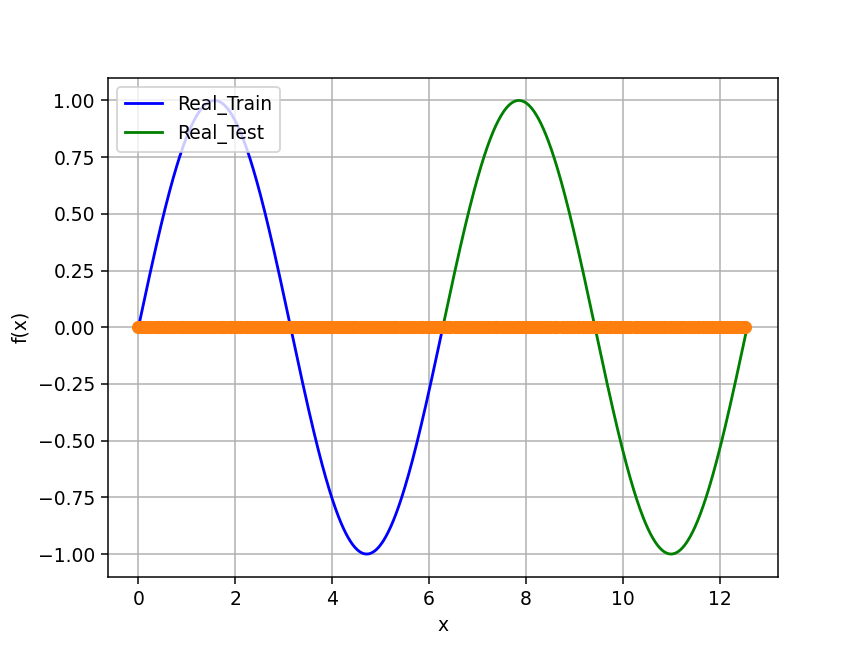

In [7]:
fig, ax1 = plt.subplots()
ax1.plot(x.detach().numpy(),y.detach().numpy(),color='blue',label='Real_Train')
ax1.plot(x_test.detach().numpy(),y_test.detach().numpy(),color='green',label='Real_Test')
#ax1.plot(x_train.detach().numpy(),yh.detach().numpy(),color='red',label='Pred_Train')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('f(x)',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper left')
ax1.grid()

In [8]:
#def get_training_data(x):
#Nu: Number of training point, # Nf: Number of collocation points
# Set Boundary conditions:
BC_1=x[0,:]
BC_2=x[-1,:]
# Total Training points BC1+BC2
all_train=torch.vstack([BC_1,BC_2])
#Select Nu points
idx = np.random.choice(all_train.shape[0], Nu, replace=False) 
x_BC=all_train[idx]
#Select Nf points
# Latin Hypercube sampling for collocation points 
x_PDE = BC_1 + (BC_2-BC_1)*lhs(1,Nf) #lhs: latin-hypercube sampling: no generated sample will be repeated.
x_PDE = torch.vstack((x_PDE,x_BC)) 

In [9]:
x_PDE.shape

torch.Size([252, 1])

# Train Neural Network with PDE collocation

In [11]:
#Store tensors to GPU
torch.manual_seed(123)
x_PDE=x_PDE.float().to(device)
x_BC=x_BC.to(device)
#Create Model
model = FCN(layers)
print(model)
model.to(device)
params = list(model.parameters())
optimizer = torch.optim.Adam(model.parameters(),lr=lr,amsgrad=False)
start_time = time.time()

FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=1, bias=True)
  )
)


In [12]:
for i in range(steps):
    yh = model(x_PDE)
    loss = model.loss(x_PDE,x_BC)# use mean squared error
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%(steps/10)==0:
      print(i,loss)

tensor(1.5131, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.4012e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.4034e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.3722e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.2077e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.0131e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.9480e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0908e-05, device='cuda:0', grad_fn=<AddBackward0>)


### Plots

In [13]:
# Function
yh=model(x.to(device))
y=f_BC(x)

#Error
print(model.lossBC(x.to(device)))

yh_test=model(x_test.to(device))
y_test=f_BC(x_test)

print(model.lossBC(x_test.to(device)))

tensor(1.5625e-05, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(3.5395, device='cuda:0', grad_fn=<MseLossBackward>)


In [14]:
# Derivative
g=x.to(device)
g=g.clone()
g.requires_grad=True #Enable differentiation
f=model(g)
f_x=autograd.grad(f,g,torch.ones([g.shape[0],1]).to(device),retain_graph=True, create_graph=True)[0]

In [15]:
# Detach from GPU
y_plot=y.detach().numpy()
yh_plot=yh.detach().cpu().numpy()
f_x_plot=f_x.detach().cpu().numpy()

y_test_plot=y_test.detach().numpy()
yh_test_plot=yh_test.detach().cpu().numpy()

<IPython.core.display.Javascript object>


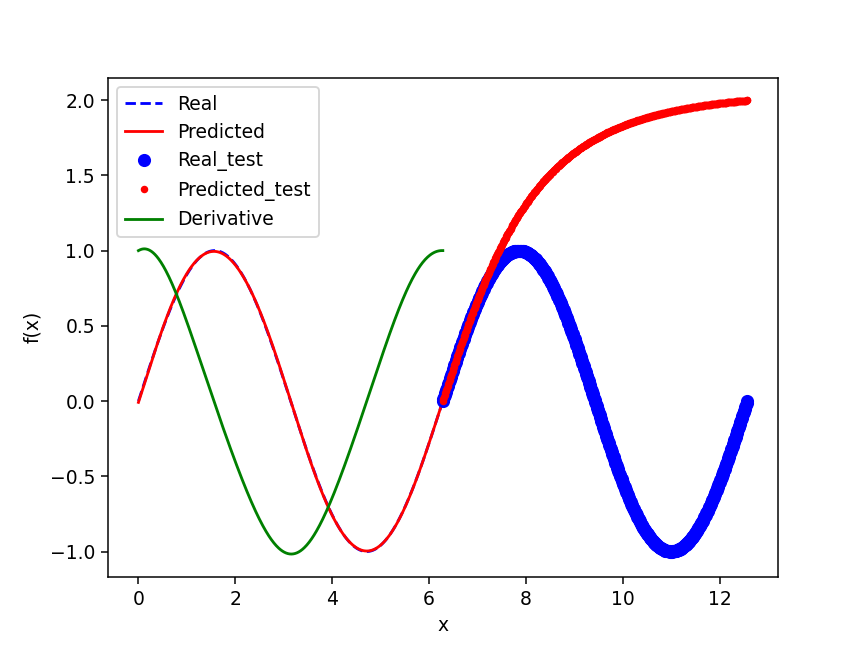

In [16]:
# Plot
fig, ax1 = plt.subplots()
ax1.plot(x,y_plot,'--',color='blue',label='Real')
ax1.plot(x,yh_plot,color='red',label='Predicted')
ax1.plot(x_test,y_test_plot,'o',color='blue',label='Real_test')
ax1.plot(x_test,yh_test_plot,'.',color='red',label='Predicted_test')

ax1.plot(x,f_x_plot,color='green',label='Derivative')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('f(x)',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper left')

## The resutls shows us two things: 
* the predicted points are accurate within the range of two boundary conditions f_BC(0)=0 and f_BC(2pi)=0. It is because the collocation points are sampled between this range.
* the prediction is bad when when the test point is outside the range. 

## The possible solutions are two that are going to be tested
* smaple collocation points to 4pi
* KAN networks that learn the function

In [34]:
x_PDE = BC_1 + (x_test[-1,0]-BC_1)*lhs(1,Nf) #lhs: latin-hypercube sampling: no generated sample will be repeated.
x_PDE = x_PDE.float().to(device)
x_PDE = torch.vstack((x_PDE,x_BC)) 

In [28]:
#Create Model
model2 = FCN(layers)
model2.to(device)
params = list(model2.parameters())
optimizer = torch.optim.Adam(model2.parameters(),lr=lr,amsgrad=False)

In [43]:
for i in range(steps):
    yh = model2(x_PDE)
    loss = model2.loss(x_PDE,x_BC)# use mean squared error
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%(steps/10)==0:
      print(i,loss)

0 tensor(1.7817, device='cuda:0', grad_fn=<AddBackward0>)
500 tensor(0.0159, device='cuda:0', grad_fn=<AddBackward0>)
1000 tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
1500 tensor(7.6042e-05, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(3.7464e-05, device='cuda:0', grad_fn=<AddBackward0>)
2500 tensor(1.8751e-05, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(9.0172e-06, device='cuda:0', grad_fn=<AddBackward0>)
3500 tensor(1.1883e-05, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(5.1414e-06, device='cuda:0', grad_fn=<AddBackward0>)
4500 tensor(3.2750e-06, device='cuda:0', grad_fn=<AddBackward0>)


<IPython.core.display.Javascript object>


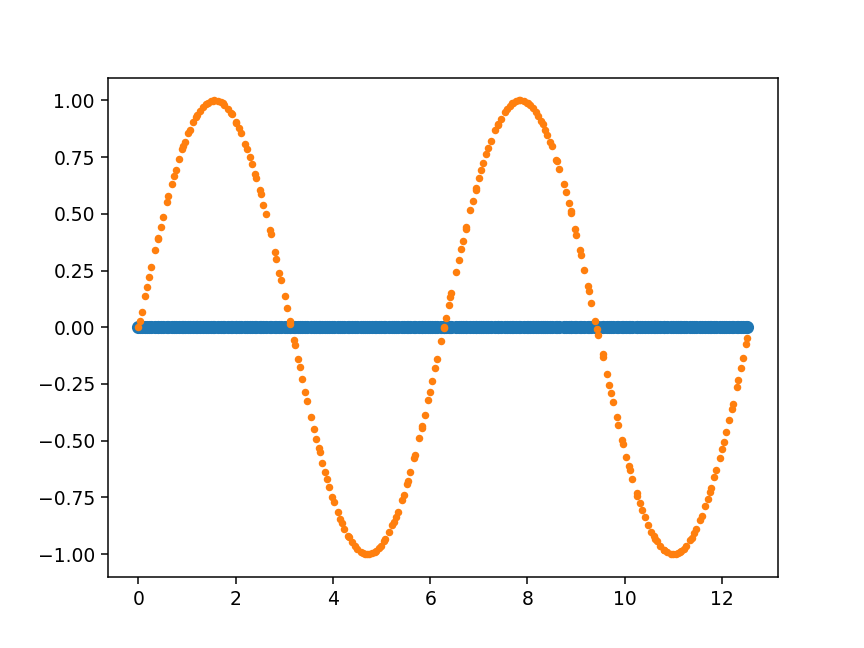

In [44]:
fig, ax1 = plt.subplots()
ax1.plot(x_PDE.cpu().numpy(), torch.zeros(x_PDE.shape),"o")
ax1.plot(x_PDE.cpu().numpy(), f_BC(x_PDE).cpu().numpy(),'.')

In [46]:
yh_test2=model2(x_test.to(device))

<IPython.core.display.Javascript object>


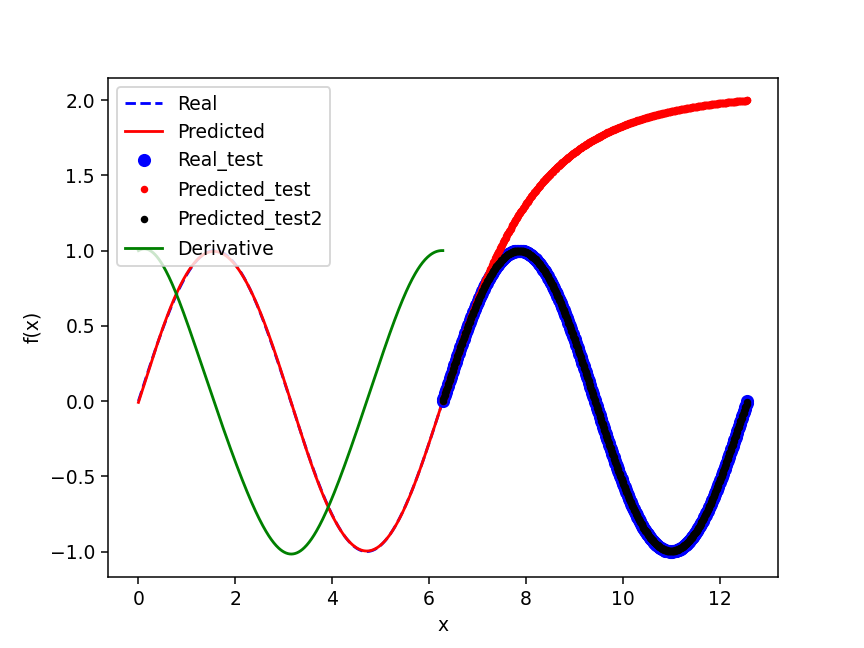

In [48]:
# Plot
fig, ax1 = plt.subplots()
ax1.plot(x,y_plot,'--',color='blue',label='Real')
ax1.plot(x,yh_plot,color='red',label='Predicted')
ax1.plot(x_test,y_test_plot,'o',color='blue',label='Real_test')
ax1.plot(x_test,yh_test_plot,'.',color='red',label='Predicted_test')
ax1.plot(x_test,yh_test2.detach().cpu().numpy(),'.',color='black',label='Predicted_test2')

ax1.plot(x,f_x_plot,color='green',label='Derivative')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('f(x)',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper left')

## This shows us that PINNS has to have collocation points cover all posible range for test. It can not extrapolate the data correctly. It is worth to mention the purpose of physic-informed Neural network benefit